In [ ]:
import numpy as np
import glob
import os
from models.JetPointNet import PointNetSegmentation


def load_data_from_npz(npz_file):
    data = np.load(npz_file)
    feats = data['feats']  # Shape: (num_samples, 859, 6)
    frac_labels = data['frac_labels']  # Shape: (num_samples, 859)
    tot_labels = data['tot_labels']  # Shape: (num_samples, 859)
    tot_truth_e = data['tot_truth_e']  # Shape: (num_samples, 859) (This is the true total energy deposited by particles into this cell)
    return feats, frac_labels, tot_labels, tot_truth_e

# Setup
os.environ['CUDA_VISIBLE_DEVICES'] = ""  # Disable GPU
abs_model_path = "saved_model/PointNetModel.keras"

TEST_DIR = '/data/mjovanovic/jets/processed_files/2000_events_w_fixed_hits/SavedNpz/test'

abs_model = PointNetSegmentation(num_points=859, num_classes=1)
abs_model.load_weights(abs_model_path)

npz_files = glob.glob(os.path.join(TEST_DIR, '*.npz'))



13/13 [==============================] - 11s 878ms/step
[   0.          0.          0.          0.          0.          0.
   33.726475  103.66601    98.27175  1088.3453     38.555458  175.8548
   73.287674   10.619699   56.940617   61.281555   48.854305   12.892978
  178.95758    35.940475   49.260612   34.116974   53.61529    50.904427
   55.65225    97.75687    17.005993   72.911385  157.84833    27.748865
  226.7279     55.4985     76.64555    27.905945  129.6377     17.204624
   27.814487   66.36075   100.544754  165.51709   215.14914    32.24269
  247.28348   280.9436     23.66187    67.15261    36.323044  182.08908
   74.91393    61.155247   40.09523    62.21918    53.04401    56.149036
  196.3696     31.851313   30.052837  192.96848    13.040064  220.8213
   12.917725   64.727905  319.38562    89.71377   219.46909   167.77419
   48.938107  147.68571    45.200726  303.86453    29.53692    29.788021
  113.78702    23.406212  124.74266    13.020414   28.044744  113.918976
  253.28

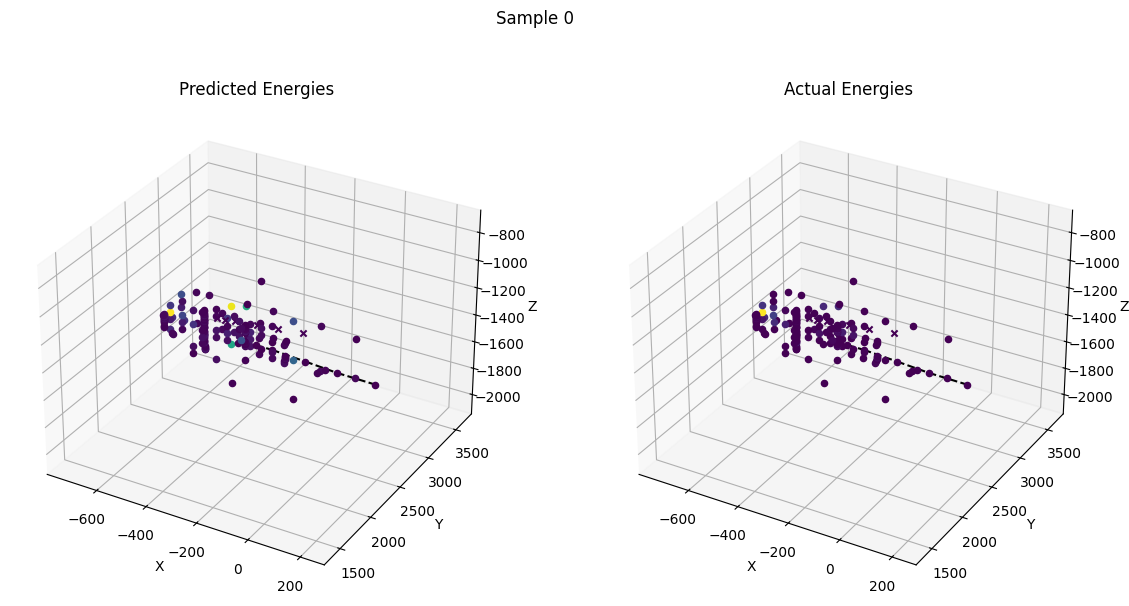

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.16260262e+01
 3.74419702e+03 5.69437012e+02 8.46317627e+02 3.70325592e+02
 7.00984192e+01 7.24524048e+02 2.10230011e+02 4.79658789e+03
 1.01575661e+02 1.54894257e+01 2.03131084e+01 7.04139280e+00
 4.24686584e+01 1.49274511e+01 5.75616608e+01 7.95366144e+00
 1.10159788e+01 9.73612690e+00 4.25694618e+01 1.20562286e+02
 1.15169020e+01 2.11655624e+02 3.11161060e+01 3.93856140e+02
 1.95504169e+01 5.07081848e+02 2.40441532e+01 1.04537683e+03
 8.00562805e+02 3.12561512e+01 3.80107758e+02 6.21497917e+00
 2.30693481e+02 6.22397804e+00 1.15004509e+02 8.12796249e+01
 1.16467762e+01 4.38653564e+01 2.88912392e+01 3.82427902e+01
 9.91226864e+00 4.29579582e+01 4.76907387e+01 5.12855072e+01
 8.54169312e+01 4.29131546e+01 2.18870544e+02 6.40839355e+02
 5.46691227e+00 4.69968719e+02 2.28294353e+01 2.56772369e+02
 3.67434143e+02 7.28079271e+00 2.23376724e+02 1.07887451e+02
 1.18684235e+01 4.848357

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_energies(predicted_energies, true_energies, coords, types, sample_index):
    # Updated function to handle plotting based on point types
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.set_title('Predicted Energies')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax2.set_title('Actual Energies')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # Adjust colors and markers based on point types
    for i, t in enumerate(types):
        color = 'r' if t == 2 else 'b'  # Red for type 2, blue for others
        marker = 'x' if t == 2 else 'o'  # 'x' for type 2, 'o' for others
        linestyle = 'k--' if t == 1 else 'none'  # Dotted line for type 1

        if t == -1:
            continue  # Skip points of type -1

        ax1.scatter(coords[i, 0], coords[i, 1], coords[i, 2], c=predicted_energies[i], cmap='viridis', vmin=0, vmax=np.max(predicted_energies), marker=marker)
        ax2.scatter(coords[i, 0], coords[i, 1], coords[i, 2], c=true_energies[i], cmap='viridis', vmin=0, vmax=np.max(true_energies), marker=marker)

        if i > 0 and types[i-1] == 1 and t == 1:
            # Connect points of type 1 with a black dotted line
            ax1.plot([coords[i-1, 0], coords[i, 0]], [coords[i-1, 1], coords[i, 1]], [coords[i-1, 2], coords[i, 2]], 'k--')
            ax2.plot([coords[i-1, 0], coords[i, 0]], [coords[i-1, 1], coords[i, 1]], [coords[i-1, 2], coords[i, 2]], 'k--')

    plt.suptitle(f'Sample {sample_index}')
    plt.show()

# Process each file
for npz_file_idx, npz_file in enumerate(npz_files):
    if npz_file_idx > 1:  # Only plot the first 10 samples
        break
    feats, frac_labels, tot_labels, tot_truth_e = load_data_from_npz(npz_file)
    abs_predicted = np.abs(np.squeeze(abs_model.predict(feats), axis=-1))

    for sample_idx in range(min(10, len(feats))):
        types = feats[sample_idx][:, -1]
        valid_indices = types != -1  # Exclude -1 types for plotting

        # Extract coordinates and types for plotting
        coords = feats[sample_idx][valid_indices, :3]
        types_for_plotting = types[valid_indices]

        # For energy evaluation, consider only type 0
        energy_indices = types == 0
        predicted_energies_eval = abs_predicted[sample_idx] * energy_indices
        true_energies_eval = tot_labels[sample_idx] * energy_indices

        #print(predicted_energies_eval)

        tot_predicted = np.sum(predicted_energies_eval)
        tot_true = np.sum(true_energies_eval)
        print("Predicted Energy: ", tot_predicted)
        print("True Energy: ", tot_true)
        print("Percentage Difference: ", 100 * np.abs(tot_predicted - tot_true) / tot_true, "% ")
        #print(predicted_energies_eval)
        #print(true_energies_eval)

        # Convert types for energy evaluation to boolean for indexing, zero out non-type 0 energies
        predicted_energies_plot = np.abs(abs_predicted[sample_idx][valid_indices])
        true_energies_plot = np.abs(tot_labels[sample_idx][valid_indices])

        # Plot with adjusted energies
        plot_energies(predicted_energies_plot, true_energies_plot, coords, types_for_plotting, sample_idx)
